In [1]:
%load_ext tensorboard

In [5]:
!kill 29407

In [3]:
%tensorboard --logdir logs/unet

In [4]:
from argparse import ArgumentParser
from data import TGSTransform, TGSSaltDataset, collate_fn
import matplotlib.pyplot as plt
from train import LitUNet
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
from utils import calculate_mAP
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [4]:
p = torch.load('logs/iter01/01/ckpt/01/epoch=49-step=9999.ckpt')

In [5]:
p.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [9]:
from model import UNet

In [10]:
m = UNet(1, 1)

In [13]:
p = torch.load('logs/iter01/01/ckpt/01/epoch=49-step=9999.ckpt')
s = { k[6:]:v for k,v in p['state_dict'].items()}

In [14]:
m.load_state_dict(s)

RuntimeError: Error(s) in loading state_dict for UNet:
	size mismatch for inc.double_conv.0.weight: copying a param with shape torch.Size([64, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 1, 3, 3]).
	size mismatch for inc.double_conv.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.3.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for inc.double_conv.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for inc.double_conv.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for down1.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for down1.maxpool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for down1.maxpool_conv.1.double_conv.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down1.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for down2.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for down2.maxpool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for down2.maxpool_conv.1.double_conv.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down2.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for down3.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for down3.maxpool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for down3.maxpool_conv.1.double_conv.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down3.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.0.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for down4.maxpool_conv.1.double_conv.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.3.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for down4.maxpool_conv.1.double_conv.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.4.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for down4.maxpool_conv.1.double_conv.4.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.0.weight: copying a param with shape torch.Size([512, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for up1.conv.double_conv.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for up1.conv.double_conv.3.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 3, 3]).
	size mismatch for up1.conv.double_conv.3.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up1.conv.double_conv.4.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up1.conv.double_conv.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up1.conv.double_conv.4.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up1.conv.double_conv.4.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.0.weight: copying a param with shape torch.Size([256, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 64, 3, 3]).
	size mismatch for up2.conv.double_conv.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for up2.conv.double_conv.3.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 3, 3]).
	size mismatch for up2.conv.double_conv.3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up2.conv.double_conv.4.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up2.conv.double_conv.4.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up2.conv.double_conv.4.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up2.conv.double_conv.4.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.0.weight: copying a param with shape torch.Size([128, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 3, 3]).
	size mismatch for up3.conv.double_conv.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for up3.conv.double_conv.3.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 16, 3, 3]).
	size mismatch for up3.conv.double_conv.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up3.conv.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up3.conv.double_conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up3.conv.double_conv.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up3.conv.double_conv.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.0.weight: copying a param with shape torch.Size([64, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 16, 3, 3]).
	size mismatch for up4.conv.double_conv.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.1.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.1.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.1.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.3.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for up4.conv.double_conv.3.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.4.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.4.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for up4.conv.double_conv.4.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for outc.conv.weight: copying a param with shape torch.Size([1, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 8, 1, 1]).

In [ ]:
m

In [5]:
root_ds = 'dataset'
img_size_ori = 101
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True, use_depth=False))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False, use_depth=False))

print(len(train_ds), len(val_ds))
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_fn, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, num_workers=4, collate_fn=collate_fn)

3200 800


In [6]:
val_iter = iter(val_dl)

In [7]:
batch = next(val_iter)

torch.Size([8, 64, 128, 128])


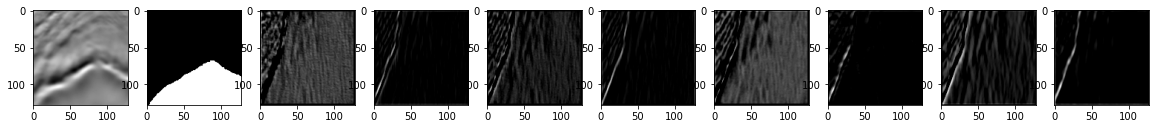

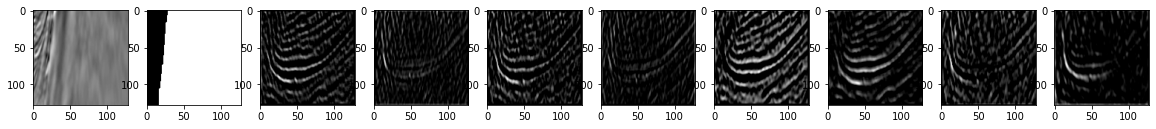

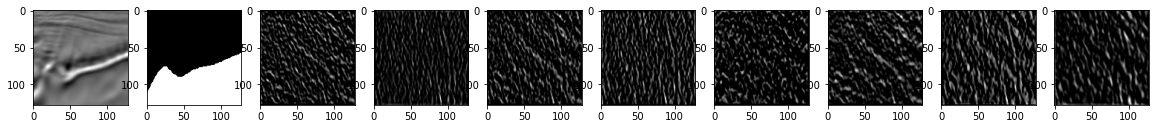

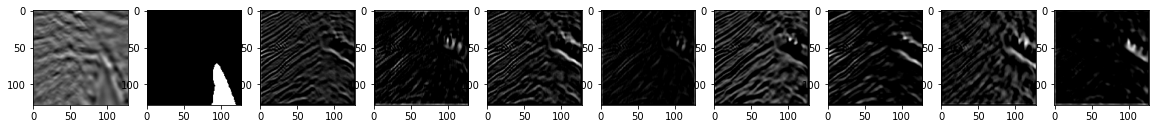

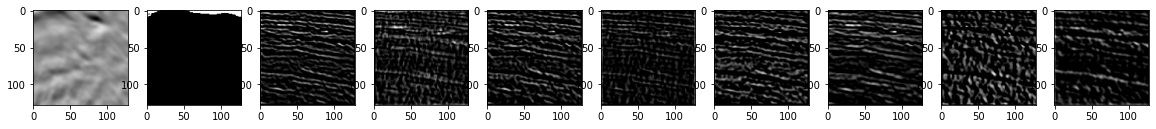

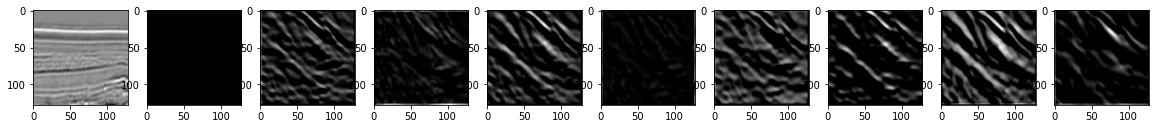

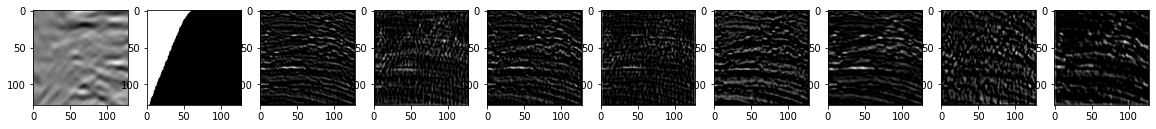

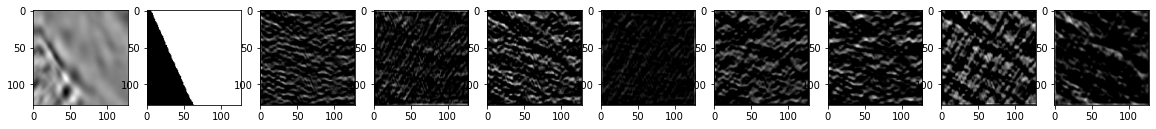

In [48]:
m.eval()
m.cuda()
with torch.no_grad():
    l1 = m.inc(batch[0].cuda())
    print(l1.size())
    for img, msk, l in zip(b[0], b[1], l1):
        _img = img[0].squeeze(0)
        _msk = msk.squeeze(0).round()
        fig,_ = plt.subplots(nrows=1, ncols=10, figsize=(20, 16))
        fig.axes[0].imshow(_img, cmap='gray')
        fig.axes[1].imshow(_msk, cmap='gray')
        for i in range(8):
            _att = l[i].squeeze().cpu().numpy()
            fig.axes[2 + i].imshow(_att, cmap='gray')


    plt.show()

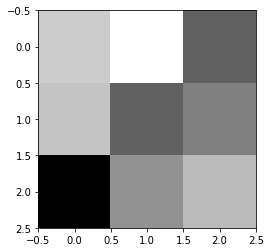

In [39]:
k = m.inc.double_conv[0].state_dict()['weight'][0, 0].cpu()
plt.imshow( (k - k.min()) / (k.max() - k.min()) , cmap='gray')

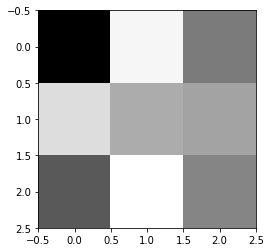

In [40]:
k = m.inc.double_conv[0].state_dict()['weight'][1, 0].cpu()
plt.imshow( (k - k.min()) / (k.max() - k.min()) , cmap='gray')

In [8]:
m.eval()
m.cuda()
with torch.no_grad():
    x1 = m.inc(batch[0].cuda())
    x2 = m.down1(x1)
    x3 = m.down2(x2)
    x4 = m.down3(x3)
    x5 = m.down4(x4)
    y1 = m.up1(x5, x4)
    y2 = m.up2(y1, x3)
    y3 = m.up3(y2, x2)
    y4 = m.up4(y3, x1)
    logits = m.outc(y4)

NameError: name 'm' is not defined

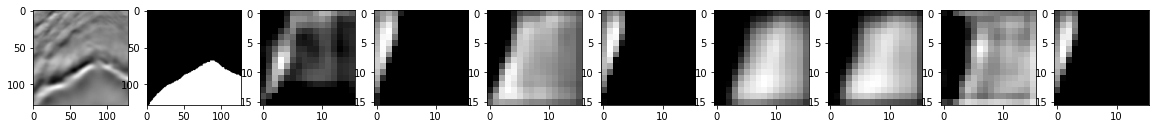

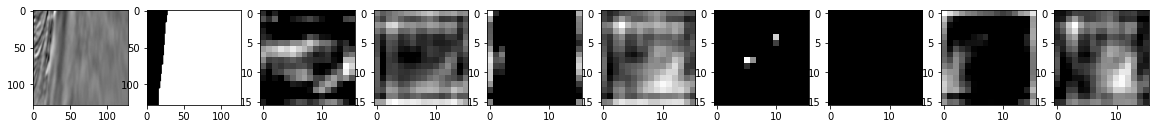

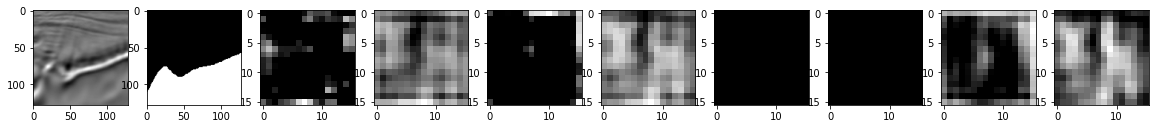

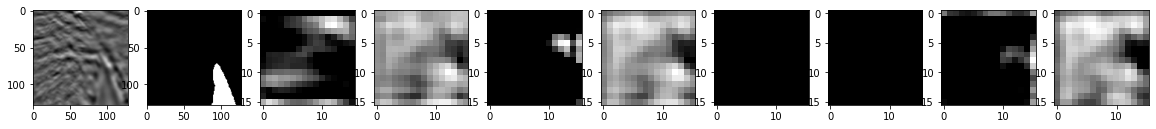

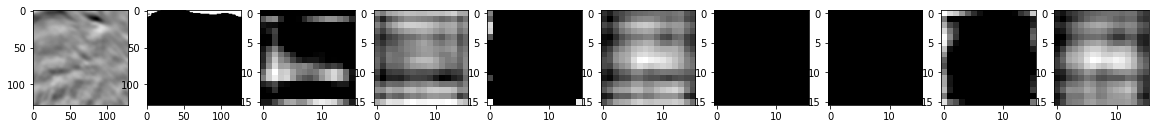

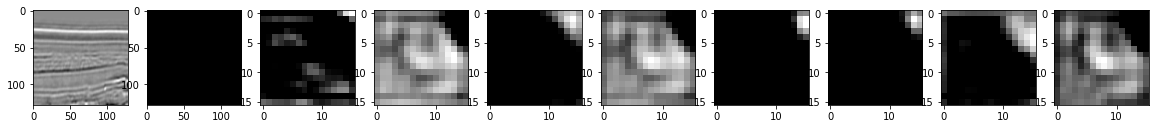

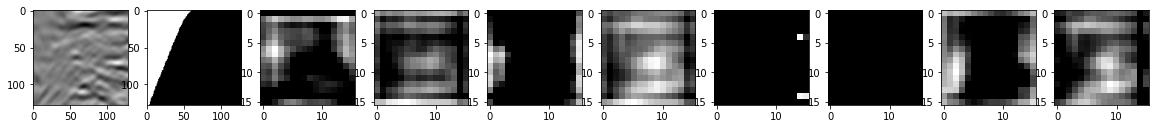

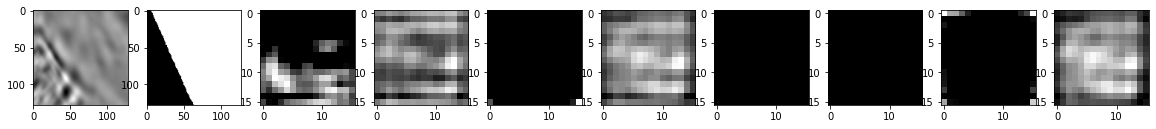

In [57]:
m.eval()
m.cuda()
with torch.no_grad():
    for img, msk, l in zip(b[0], b[1], y1):
        _img = img[0].squeeze(0)
        _msk = msk.squeeze(0).round()
        fig,_ = plt.subplots(nrows=1, ncols=10, figsize=(20, 16))
        fig.axes[0].imshow(_img, cmap='gray')
        fig.axes[1].imshow(_msk, cmap='gray')
        for i in range(8):
            _att = l[i].squeeze().cpu().numpy()
            fig.axes[2 + i].imshow(_att, cmap='gray')
    plt.show()

In [71]:
batch[0].size()

torch.Size([8, 1, 128, 128])

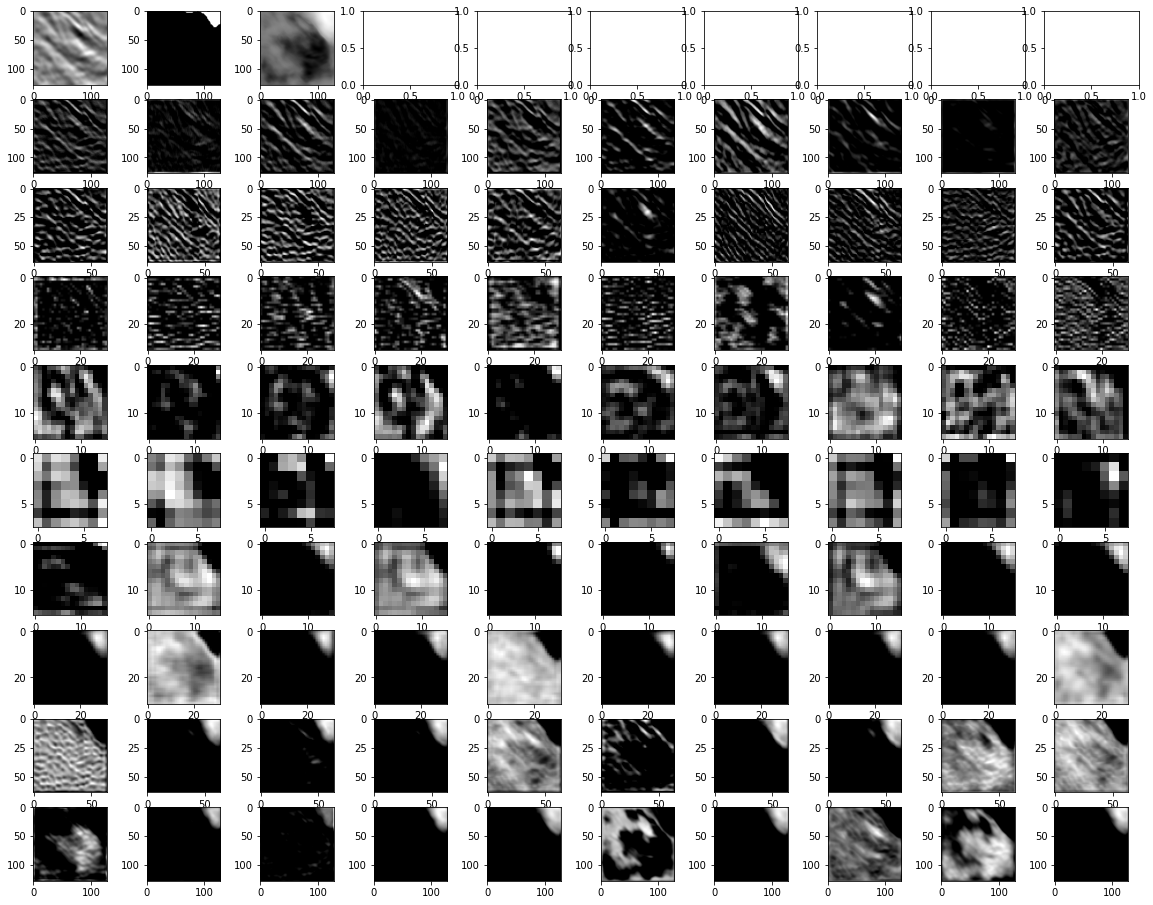

In [78]:
idx = 5
img = batch[0][idx]
mask = batch[1][idx]
_img = img.squeeze(0)
_msk = mask.squeeze(0).round()
inside = [fm[idx] for fm in [x1, x2, x3, x4, x5, y1, y2, y3, y4]]
fig, axs = plt.subplots(nrows=len(inside) + 1, ncols=10, figsize=(20, 16))
axs[0, 0].imshow(_img, cmap='gray')
axs[0, 1].imshow(_msk, cmap='gray')
axs[0, 2].imshow(logits[idx].squeeze().cpu().numpy(), cmap='gray')

for i, fm in enumerate(inside):
    for j in range(10):
        _att = fm[j].squeeze().cpu().numpy()
        axs[i + 1, j].imshow(_att, cmap='gray')
plt.show()

In [3]:
plt.imshow(y1[idx, 1])

NameError: name 'plt' is not defined